# Introduction to Probabilistic Graphical Models
## Practical Session 1
### Author: Xiang Yu, Email: shawnxiangyu@yahoo.com

In [1]:
%matplotlib inline
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
import networkx as nx
import pyparsing
from IPython.display import Math
import copy

import warnings
warnings.filterwarnings("ignore")

### Question 0

We often need to compute    
$$
s= log\sum_{i=1}^I \exp(v_i)
$$
where each $v_i < 0$ and $|v_i|$ is very large. The direct calculation of $s$ may not be numerically stable. Therefore, we propose the calculation as the following: 
$$
  V_{max} = \max_{i} v_i 
$$
Then, 
\begin{align}
s &= log\sum_{i=1}^I \exp(v_i) \\
 & = log\sum_{i=1}^I \exp(v_i- V_{max} + V_{max}) \\
 & = log\sum_{i=1}^I \exp(v_i- V_{max}) * exp(V_{max}) \\
 & = V_{max} + log\sum_{i=1}^I \exp(v_i- V_{max})
\end{align}

We define function L for later calculation
$$
L(v_i) =  V_{max} + log\sum_{i=1}^I \exp(v_i- V_{max})
$$
    
    

In [2]:
####Q0
def naive_logsum_exp(xs):     
    return np.log(np.sum(np.exp(xs)))

def stable_logsumexp(xs): 
    max_xs = np.max(xs)
    nr_xs = len(xs)
    vi_vmax = xs - max_xs   
    return max_xs + np.log(np.sum(np.exp(vi_vmax)))

# calculate the result for q0:
xs = [-1234, -1235]
naive_s = naive_logsum_exp(xs) 
stable_s = stable_logsumexp(xs)

print("Naivie and stable solution are: ", naive_s, ',', stable_s)

Naivie and stable solution are:  -inf , -1233.6867383124818


### Q0: Explain why it should work: 
When $v_i < 0$ and $|v_i|$ is very large, $\exp(v_i)$ will be extremly small and could easily be over the machine precision, the machine may think then the returned value will be zero,  and $log(0)$ will return infinity. 

With the stable method, $v_i- V_{max}$ will always be smaller or equal to zero and one element of $v_i- V_{max}$ will be zero, leading to $log\sum_{i=1}^I \exp(v_i- V_{max})$ strictly positive, and when plusing a constant $V_{max}$, the result will be numerically stable. 

### Q1 

####   Q1.1
The position domain will be $PD = \{1, 2, ..., N\}$. The action domain will be $AD = \{0, 1\}$, here $0$ means the robot stays where it is and $1$ means the robot moves to the next point in the counter-clock direction. 
The variables are as follows: 

- $x_k$, the actual position at each step, where $x_k \in PD$
- $y_k$, the observed position at each step, where $y_k \in PD$
- $a_k$, the action taken at each step, where $a_k \in AD$


The generative model is as follows: 

$$\large p(x_{1:k} , y_{1:k}) = \{\pi_{i=2}^{k}p(y_i|x_i)p(x_i|x_{i-1})\}p(x_1)p(y_1|x_1)$$



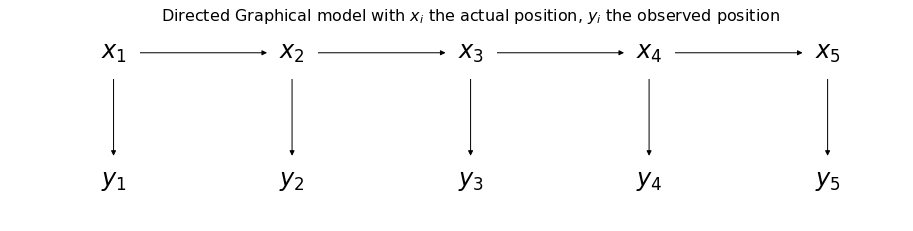

In [3]:
### draw the accociated directed graphical model
# This section code coming from : https://github.com/atcemgil/notes/blob/master/HiddenMarkovModel.ipynb
def makeDBN(inter, intra, T, labels):
    """Unfold a graph for T time slices"""
    N = max(max([i for i,j in inter]),max([j for i,j in inter]))+1

    G = np.zeros((N*T,N*T))
    pos = []
    all_labels = []
    for n in range(N):
        pos.append((0,-n))
        all_labels.append('$'+labels[n]+'_{'+str(0+1)+"}"+'$')
        
    for e in inter:
        s,d = e
        G[s,d] = 1

    for t in range(1,T):
        for n in range(N):
            pos.append((t,-n))
            all_labels.append('$'+labels[n]+'_{'+str(t+1)+"}"+'$')

        for e in inter:
            s,d = e
            s = s + N*t
            d = d + N*t
            G[s,d] = 1
        
        for e in intra:
            s,d = e
            s = s + N*(t-1)
            d = d + N*t
            G[s,d] = 1
    return G,pos,all_labels


np.set_printoptions(precision=5, suppress=True)
inter = [(0,1)]
intra = [(0,0)]
variable_names = ["x", "y"] 
T = 5
A, pos, label_list = makeDBN(inter, intra, T, variable_names)

G = nx.DiGraph(A)
labels = {i: s for i,s in enumerate(label_list)}
plt.figure(figsize=(12,2.5))
nx.draw(G, pos, node_color="white", node_size=2500, labels=labels, font_size=24, arrows=True)
plt.title(r'Directed Graphical model with $x_i$ the actual position, $y_i$ the observed position', fontsize=16)
plt.show()

####   Q1.2

The transition model is: $x_k \sim p(x_k | x_{k-1})$ and the observation model is: 
$y_k \sim p(y_k | x_k)$. 

$$
p(x_1 = i) = \frac{1}{N} \\
p(y_1 = i | x_1 = i) = w  + \frac{1}{N} *(1-w)\\ 
p(y_1 = i  | x_1 = j) = \frac{1}{N} *(1-w), where \ i \neq j\\
p(x_2 = i | x_1 = i) = \epsilon \\
p(x_2 = j | x_1 = i) = 1 - \epsilon \\
$$


Where  $j = mod(i - 1 + N, N)$,i.e. a counter-clock direction position next to $i$   
$$
p(x_2 = k | x_1 = i) = 0
$$
where $k \neq i $ and $ k \neq j $, with $j$ the same definition as above.
$$
p(y_2 = i | x_k = i) =  w + \frac{1-w}{N} \\
...
$$



$$
p(x_k = i | x_{k-1} = i) = \epsilon \\
p(x_k = j | x_{k-1} = i) = 1 - \epsilon, j \ counter-clock \  position \ next\  to \  i\\
p(x_k = k | x_{k-1} = i) = 0, k \neq i \ and \  k \neq j \\
p(y_k = i | x_k = i) = w + \frac{1-w}{N} \\
p(y_k = i  | x_k = j) = \frac{1}{N} *(1-w), where \ i \neq j
$$



The transition model written in a matrix form, with  $j = mod(i - 1 + N, N)$, i.e. a counter-clock direction position next to $i$ ; when i = 1, j will be equal to N: 
$$p(x_{k+1}|x_k=i)= \begin{pmatrix}
 0   \\
...  \\
1 - \epsilon  \\
\epsilon  \\
...  \\
0 
\end{pmatrix}, \ with\ \  each\  row \  corresponding\ to \ x_{k+1} = \  
\begin{pmatrix}
 1   \\
...  \\
j \\
i  \\
...  \\
N 
\end{pmatrix}  $$


The observation model in matrix form: 
$$p(y_{k}|x_k=i)= \begin{pmatrix}
 \frac{1-w}{N}    \\
...  \\
 \frac{1-w}{N}  \\
w +  \frac{1-w}{N}  \\
 \frac{1-w}{N}  \\
...  \\
 \frac{1-w}{N} 
\end{pmatrix}, \ with\ \  each\  row \  corresponding\ to \ y_{k} = \  
\begin{pmatrix}
 1   \\
...  \\
i-1 \\
i  \\
i+1 \\
...  \\
N 
\end{pmatrix}  $$

####   Q1.3

We define: 
$$
\large p(x_k, y_{1:k}) =  \alpha_{k|k}(x_k) \\
\large p(x_k, y_{1:k-1}) = \alpha_{k|k-1}(x_k) \\
\large p(y_{k:N}|x_k) = \beta_{k|k}(x_k) \\
\large p(y_{k+1:N}|x_k) = \beta_{k|k+1}(x_k) \\
\large \beta_{N|N+1}(x_N) = 1
$$
Where $N$ is the total number of time steps



(a) Distribution of the robot’s current position given the observations so far, i.e. the filtering distribution: 

$$\large p(x_k | y_{1:k}) = \frac{p(x_k,  y_{1:k})}{p(y_{1:k})} = \frac{\alpha_{k|k}(x_k)}{\sum_{x_k}p(x_k, y_{1:k})} = \frac{\alpha_{k|k}(x_k)}{\sum_{x_k}\alpha_{k|k}(x_k)}$$



(b) Distribution of the robot’s position at time step k given all the observations, i.e. the smoothing distribution: $\large p(x_k | y_{1:N})$. 

we have
$$\large
\begin{align*}
p(x_k , y_{1:N}) &= p(x_k, y_{1:k}, y_{k+1:N}) = p(x_k, y_{1:k}) p(y_{k+1:N}|x_k, y_{1:k}) \\
   &= p(x_k, y_{1:k}) p(y_{k+1:K}|x_k) =  \alpha_{k|k}(x_k)  \beta_{k|k+1}(x_k) 
\end{align*}
$$
Then, 

$$\large
\begin{align*}
p(x_k | y_{1:N}) &= \frac{p(x_k , y_{1:N})}{p(y_{1:N})} =  \frac{\alpha_{k|k}(x_k)\beta_{k|k+1}(x_k)}{\sum_{x_N}p(y_{1:N}, X_N)} \\
& = \frac{\alpha_{k|k}(x_k)\beta_{k|k+1}(x_k)}{\sum_{x_N}\alpha_{N|N}(x_N)} 
\end{align*}
$$

(c) Distribution of the robot’s next position given the observations so far, i.e. predictive distribution $p(x_{k+1}|y_{1:k})$, where we know $y_{1:k}$

$$\large
\begin{align*}
p(x_{k+1}|y_{1:k}) &= \frac{p(x_{k+1},y_{1:k})}{p(y_{1:k})} = \frac{\alpha_{k+1|k}(x_{k+1})}{\sum_{x_k}\alpha_{k|k}(x_k)} 
\end{align*}
$$

(d) Distribution of the robot’s next sensor reading given the observations so far

$$
\large p(y_{k+1}|y_{1:k}) = \frac{p(y_{k+1},y_{1:k})}{p(y_{1:k})}
$$
Where
$$\large
\begin{align*}
p(y_{k+1},y_{1:k}) &= p(y_{1:k+1}) \\
    &= \sum_{x_1, x_2, \ ...,\ x_{k+1}} p(y_{1:k+1}, x_{1:k+1}) \\
    &= \sum_{x_1, x_2, \ ...,\ x_{k+1}}p(x_1)p(y_1|x_1)\pi_{n=2}^{k+1}p(x_n|x_{n-1})p(y_n|x_n) \\
    &= \sum_{x_1, x_2, \ ...,\ x_{k+1}}p(y_{k+1}|x_{k+1})p(x_{k+1}|x_{k})  ...p(y_{2}|x_{2})p(x_2|x_{1})p(y_{1}|x_{1})p(x_{1}) \\
    &= \sum_{x_{k+1}}p(y_{k+1}|x_{k+1})\sum_{x_k}p(x_{k+1}|x_{k})p(y_k|x_k)...  \sum_{x_2}p(x_{3}|x_{2})p(y_2|x_2)\sum_{x_1}p(x_{2}|x_{1})p(y_1|x_1)p(x_1)  \\
   &=\underbrace{\sum_{x_{k+1}} p(y_{k+1} | x_{k+1} ) \sum_{x_{k}} p(x_{k+1}|x_{k})  \dots \sum_{x_{2}} p(x_3|x_{2})
\underbrace{ p(y_{2}|x_{2}) \overbrace{ \sum_{x_{1}} p(x_2|x_{1})
\underbrace{ p(y_{1}|x_{1}) \overbrace{ p(x_1)}^{\alpha_{1|0}}}_{\alpha_{1|1}}
}^{\alpha_{2|1}} }_{\alpha_{2|2}}}_{\alpha_{k+1|k+1}} 
\end{align*}
$$

and 
$$
\large p(y_{1:k}) = \sum_{x_k}\alpha_{k|k}(x_k)
$$

(e) Distribution of the robot’s initial position given observations so far

$$\large
\begin{align*}
p(x_1|y_{1:k}) &= \frac{p(y_{1:k}|x_1)p(x_1)}{p(y_{1:k})} = \frac{p(y_1|x_1)p(y_{2:k}|x_1)p(x_1)}{p(y_{1:k})}\\
\end{align*}
$$


(f) Most likely current position of the robot given the observations so far
from (a), we have: 

$$\large p(x_k | y_{1:k}) = \frac{p(x_k,  y_{1:k})}{p(y_{1:k})} = \frac{\alpha_{k|k}(x_k)}{\sum_{x_k}p(x_k, y_{1:k})} = \frac{\alpha_{k|k}(x_k)}{\sum_{x_k}\alpha_{k|k}(x_k)}$$

Then, most likely current position will be: 
$$\large
\begin{align*}
x_k^* = arg \max_{x_k}p(x_k|y_{1:k}) = arg \max_{x_k}\frac{\alpha_{k|k}(x_k)}{\sum_{x_k}\alpha_{k|k}(x_k)}
\end{align*}
$$


(g) Most likely trajectory taken by the robot from the start until now given the observations so far

$$\large
\begin{align*}
x_{1:k}^* &= arg \max_{x_{1:k}}p(x_{1:k}|y_{1:k}) \\
&= arg \max_{x_{1:k}} \underbrace{ p(x_{1}|x_{2:k}, y_{1:k}) \cdots p(x_{k-2}|x_{k-1:k}, y_{1:k}) p(x_{k-1}|x_k, y_{1:k}) p(x_{k}|y_{1:k})}_{By\  conditional\  independence} \\
& = arg \max_{x_{1:k}} p(x_{1}|x_{2}, y_{1}) \cdots p(x_{k-2}|x_{k-1}, y_{1:k-2}) p(x_{k-1}|x_k, y_{1:k-1}) p(x_{k}|y_{1:k}) 
\end{align*}
$$



####   Q1.4
Implement a program that simulates this scenario; i.e., generates realizations from the movements of the robot
and the associated sensor readings. Simulate a scenario for k = 1, . . . , 100 with N = 50,  = 0.3, w = 0.8


In [7]:
### Q1.4 ###
from IPython.display import display, Math, Latex
randint = np.random.randint

nr_sc = 100 # number of scenarios
nr_ts = 120  # number of time steps
N = 50      # number of states, i.e. all possible positions

epsilon = 0.3
w = 0.8

xs = np.zeros((nr_sc, nr_ts), dtype=int)
ys = xs.copy()
#ys = np.zeros((nr_sc, N), dtype=int)
obs_model = np.ones((N,N))
tran_model = np.zeros((N,N))  # column : x_i value, row x_{i+1} value

# probility vecotor of the position of x1, x1 correponding to zero index in the matched matrix or vector
x1_prob = np.ones((N, 1)) / N 
obs_model = obs_model * (1. - w) / N

for i in np.arange(N): 
    j = np.mod(i - 1 + N, N)
    obs_model[i, i] = w + (1. - w) / N
    tran_model[i, i] = epsilon
    tran_model[j, i] = 1 - epsilon


print ('The initial position probablities vector: \n', x1_prob.T, '\n')  

print ('The transition model probablities matrix (column:' + 'x_i, row x_{i+1}' + '): \n', tran_model, '\n')  
print (r'The observatoray model probablities matrix (column: x_i, row y_i): ','\n',  obs_model)  

The initial position probablities vector: 
 [[0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
  0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
  0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
  0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]] 

The transition model probablities matrix (column:x_i, row x_{i+1}): 
 [[0.3 0.7 0.  ... 0.  0.  0. ]
 [0.  0.3 0.7 ... 0.  0.  0. ]
 [0.  0.  0.3 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.3 0.7 0. ]
 [0.  0.  0.  ... 0.  0.3 0.7]
 [0.7 0.  0.  ... 0.  0.  0.3]] 

The observatoray model probablities matrix (column: x_i, row y_i):  
 [[0.804 0.004 0.004 ... 0.004 0.004 0.004]
 [0.004 0.804 0.004 ... 0.004 0.004 0.004]
 [0.004 0.004 0.804 ... 0.004 0.004 0.004]
 ...
 [0.004 0.004 0.004 ... 0.804 0.004 0.004]
 [0.004 0.004 0.004 ... 0.004 0.804 0.004]
 [0.004 0.004 0.004 ... 0.004 0.004 0.804]]


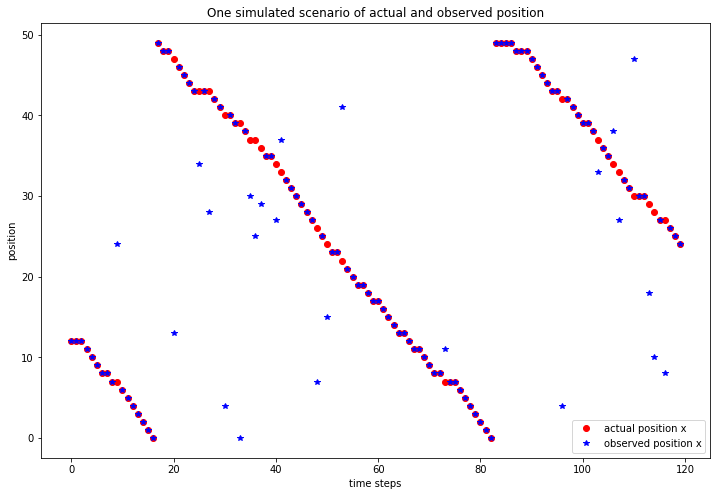

In [8]:
def sample_loc (prob, prob_distrbution): 
    # return the idx loction of prob in the prob_distrbution
    nr_loc = len(prob_distrbution)
    cum_sum = np.cumsum(prob_distrbution)  
    idx = np.where(prob < cum_sum)[0]  
    return idx[0]


# simulator the trajectory 
for ti in np.arange(0,nr_ts):   
    for si in np.arange(0, nr_sc): 
        if ti == 0: # the initial position is uniformly distributed among the N positions with 1/N probablity
            xs[si,ti] = randint(0, N)      
        else: # pi > 0
            x_ti_prob = tran_model[:,xs[si,ti-1]]
            rand_prob = np.random.uniform(0,1)  
            idx_loc = sample_loc(rand_prob, x_ti_prob) 
            xs[si, ti] = idx_loc 
        y_ti_prob = obs_model[:,xs[si,ti]]
        rand_prob = np.random.uniform(0,1)  
        idx_loc = sample_loc(rand_prob, y_ti_prob) 
        ys[si,ti] = idx_loc
        
si = 5
timesteps = np.arange(0,nr_ts)
plt.figure(figsize=(12, 8))
plt.plot(timesteps, xs[si, :],'ro', label="actual position x")  
plt.plot(timesteps, ys[si, :], 'b*', label="observed position x")  
plt.xlabel('time steps')
plt.ylabel('position')
plt.legend()
plt.title('One simulated scenario of actual and observed position')
plt.show()        


### Q1.5. 
Implement the Forward-Backward algorithm for computing the quantities defined in 3-a,b,f. (Attention: be
careful with numerical stability! Modify the log-sum-exp trick for this algorithm)            

### Some formula to be used: 
This part code coming from : https://github.com/atcemgil/notes/blob/master/HiddenMarkovModel.ipynb



### Forward Pass

\begin{eqnarray}
p(y_{1:K}) & = & \sum_{x_{1:K}} p(y_{1:K}|x_{1:K}) p(x_{1:K}) \\
& = &  \underbrace{\sum_{x_K} p(y_K | x_K ) \sum_{x_{K-1}} p(x_K|x_{K-1})  \dots \sum_{x_{2}} p(x_3|x_{2})
\underbrace{ p(y_{2}|x_{2}) \overbrace{ \sum_{x_{1}} p(x_2|x_{1})
\underbrace{ p(y_{1}|x_{1}) \overbrace{ p(x_1)}^{\alpha_{1|0}}}_{\alpha_{1|1}}
}^{\alpha_{2|1}} }_{\alpha_{2|2}}}_{\alpha_{K|K}}
\end{eqnarray}



\begin{eqnarray}
\alpha_{1|0} & \equiv & p(x_1)
\end{eqnarray}

\begin{eqnarray}
\alpha_{k|k} & \equiv & p(y_{1:k}, x_k)
\end{eqnarray}

\begin{eqnarray}
\alpha_{k|k-1}  & \equiv & p(y_{1:k-1}, x_k)
\end{eqnarray}



For $k=1, 2, \dots, K$

__Predict__

$k=1$:

\begin{eqnarray}
\alpha_{1|0}(x_1) = p(x_1)
\end{eqnarray}

$k>1$:

\begin{eqnarray}
{\alpha_{k|k-1}(x_k)} & = & p(y_{1:k-1}, x_k) = \sum_{x_{k-1}} p(x_k| x_{k-1}) p(y_{1:k-1}, x_{k-1}) \\
& = & \sum_{x_{k-1}} p(x_k| x_{k-1}) { \alpha_{k-1|k-1}(x_{k-1}) }
\end{eqnarray}

__Update__

\begin{eqnarray}
{\alpha_{k|k}(x_k) } & = & p(y_{1:k}, x_k) = p(y_k | x_k) p(y_{1:k-1}, x_k) \\
 & = & p(y_k | x_k) {\alpha_{k|k-1}(x_k)}
\end{eqnarray}


### Backward Pass


\begin{eqnarray}
p(y_{1:K}) & = &  \sum_{x_1} p(x_1) p(y_1 | x_1 )
%underbrace{\sum_{x_2} p(x_2|x_{1}) p(y_2 | x_2 )}_{\beta_1}
\dots
\underbrace{ \sum_{x_{K-1}} p(x_{K-1}|x_{K-2}) p(y_{K-1} | x_{K-1} )
\underbrace{ \sum_{x_K} p(x_K|x_{K-1}) p(y_K | x_K )
\underbrace{{\pmb 1}}_{\beta_{K|K+1}}}_{\beta_{K-1|K}}}_{\beta_{K-2|K-1}}
\end{eqnarray}


\begin{eqnarray}
\beta_{k|k+1}(x_k) & \equiv & p(y_{k+1:K}| x_k) \\
\beta_{k|k}(x_k) & \equiv & p(y_{k:K}| x_k)
\end{eqnarray}


For $k=K, K-1, \dots, 1$

'Postdict' : (Backward Prediction)

$k=K$

\begin{eqnarray}
\beta_{K|K+1}(x_K) & = & \mathbf{1} 
\end{eqnarray}


$k<K$ 
\begin{eqnarray}
\beta_{k|k+1}(x_k) & = & p(y_{k+1:K}| x_k) = \sum_{x_{k+1}} p(x_{k+1}| x_{k}) p(y_{k+1:K}| x_{k+1}) \\
& = & \sum_{x_{k+1}} p(x_{k+1}| x_{k}) \beta_{k+1|k+1}(x_{k+1}) 
\end{eqnarray}

Update
\begin{eqnarray}
\beta_{k|k}(x_k)  & = & p(y_{k:K}| x_k) = p(y_k | x_k) p(y_{k+1:K}| x_k) \\
 & = & p(y_k | x_k) {\beta_{k|k+1}(x_k)}
\end{eqnarray}


In [9]:
# Q1.5 formula:
def predict(tran_model, lp):
    # STATE_PREDICT, compute tran_model * prob in the log domain
    
    # input 
    # tran_model: State transition matrix
    # lp : log p(x_{k-1}, y_{1:k-1}) Filtered potential
    
    # output: 
    # lpp : log p(x_{k}, y_{1:k-1}); Predicted potential
    
    lstar = np.max(lp)
    return lstar + np.log(np.dot(tran_model,np.exp(lp-lstar)))


def postdict(tran_model, lp):
    # input 
    # tran_model: State transition matrix
    # lp : log p(x_{k-1}, y_{1:k-1}) Filtered potential
    
    lstar = np.max(lp)
    return lstar + np.log(np.dot(np.exp(lp-lstar), tran_model))


def update(y, logobs, lp):  
    # Inputs :
    # logobs : log(p(y_k| x_k))
    # y  : the postion of y
    # lp: log_p : log p(x_k, y_{1, k-1})
    
    # Outputs : 
    #     lup : log p(x_k, y_{1, k-1}) p(y_k| x_k)
      
    return logobs[y,:] + lp

In [10]:
#### Q1.5

# Forward Pass
alpha_1_0 = np.ones((N, 1)) / N  # alpha_1_0 = p(x_1)
# alpha_1_1 = obs_model.dot(alpha_1_0)  # alpha_1_1 = p(y_1|x_1)p(x_1) = p(y_1|x_1) alpha_1_0

# one scenario from the simulation
x = xs[si, :]
y = ys[si, :]

p = alpha_1_0.copy()
trans = tran_model.copy()  # transition model   p(x_k | x_{k_1})
obs = obs_model.copy()     # observation model  p(y_k | x_k)

log_trans = np.log(trans)
log_obs = np.log(obs)

# N: number of states/positions
# nr_ts: number of time steps

# Python indices start from zero so
log_alpha  = np.zeros((N, nr_ts))    # log \alpha_{k|k} will be in log_alpha[:,k-1]
log_alpha_pred = np.zeros((N, nr_ts))   # log \alpha_{k|k-1} will be in log_alpha_pred[:,k-1]

for ti in np.arange(nr_ts):
    if ti==0:
        log_alpha_pred[:,0] = np.log(p)[0]
    else:
        log_alpha_pred[:,ti] = predict(trans, log_alpha[:,ti-1])        
    
    log_alpha[:,ti] = update(y[ti], log_obs, log_alpha_pred[:,ti])  
    

# Backward Pass
log_beta  = np.zeros((N, nr_ts))      # beta_k|k
log_beta_post = np.zeros((N, nr_ts))  # beta_k|k+1


backward_range = np.arange(nr_ts - 1, -1, -1)
for ti in backward_range:
    if ti == nr_ts - 1:
        log_beta_post[:,ti] = np.zeros(N)
    else:
        log_beta_post[:,ti] = postdict(trans, log_beta[:,ti+1])
    log_beta[:,ti] = update(y[ti], log_obs, log_beta_post[:,ti])  

In [12]:
# Q1.5 Compute (a) Distribution of the robot’s current position given the observations so far, i.e. the filtering distribution: 
#  i.e. p(xk|y1:k),  with  y1:k given!!!

# the p(xk|y1:k) value along all the time steps, given the observed position up to the corresponding time step
p_xk_y1k = np.zeros((N, nr_ts))

for k in np.arange(nr_ts): 
    log_alpha_kk = log_alpha[:,k]
    log_sum_alpha_kk = stable_logsumexp(log_alpha[:,k])
    log_p_xk_y1k = log_alpha_kk - log_sum_alpha_kk
    p_xk_y1k[:,k] = np.exp(log_p_xk_y1k)
    

sum_p_over_path = np.sum(p_xk_y1k, axis=0)
print("\nWe check whether the probablities summing up to 1 along the path!" , 
      "\n The sum of probablities at each time step \n: ", sum_p_over_path)
    
# random choose a k 
k = 10 - 1 
print ("\nWe print the probabilties of each position for a particular time step", 
       "\n given observed position up to time k,", 
       r'$p(x_k|y_{1:k})$ = ', '\n',  p_xk_y1k[:,k])



We check whether the probablities summing up to 1 along the path! 
 The sum of probablities at each time step 
:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

We print the probabilties of each position for a particular time step 
 given observed position up to time k, $p(x_k|y_{1:k})$ =  
 [0.      0.      0.      0.      0.      0.00004 0.6985  0.30083 0.00064
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.     ]

In [13]:
# Q1.5(b) Distribution of the robot’s position at time step k given all the observations, i.e. the smoothing distribution: p(xk|y1:N)p(xk|y1:N). 

# the p(xk|y1:k) value along all the time steps, given the observation to the end
p_xk_y1N = np.zeros((N, nr_ts))

for k in np.arange(nr_ts): 
    log_alpha_kk = log_alpha[:,k]
    log_beta_post_kk = log_beta_post[:,k]
    log_sum_alpha_NN = stable_logsumexp(log_alpha[:, - 1])
    log_p_xk_y1N = log_alpha_kk +  log_beta_post_kk  -  log_sum_alpha_NN
    p_xk_y1N[:,k] = np.exp(log_p_xk_y1N)
    

sum_p_over_path = np.sum(p_xk_y1N, axis=0)
print("\nWe check whether the probablities summing up to 1 along the path!" , 
      "\n The sum of probablities at each time step \n: ", sum_p_over_path)
    
# random choose a k 
k = 10 - 1 
print ("\nWe print the probabilties of each position for a particular time step, given all observed position!", 
       r'$p(x_k|y_{1:k})$ = ', '\n',  p_xk_y1N[:,k])



We check whether the probablities summing up to 1 along the path! 
 The sum of probablities at each time step 
:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

We print the probabilties of each position for a particular time step, given all observed position! $p(x_k|y_{1:k})$ =  
 [0.      0.      0.      0.      0.      0.      0.50002 0.49998 0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.     ]


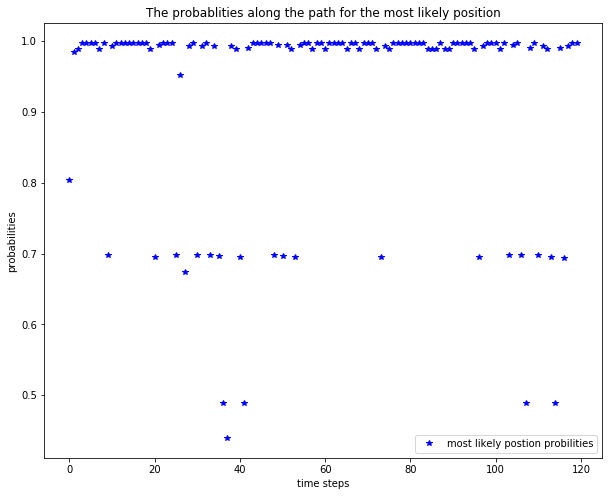

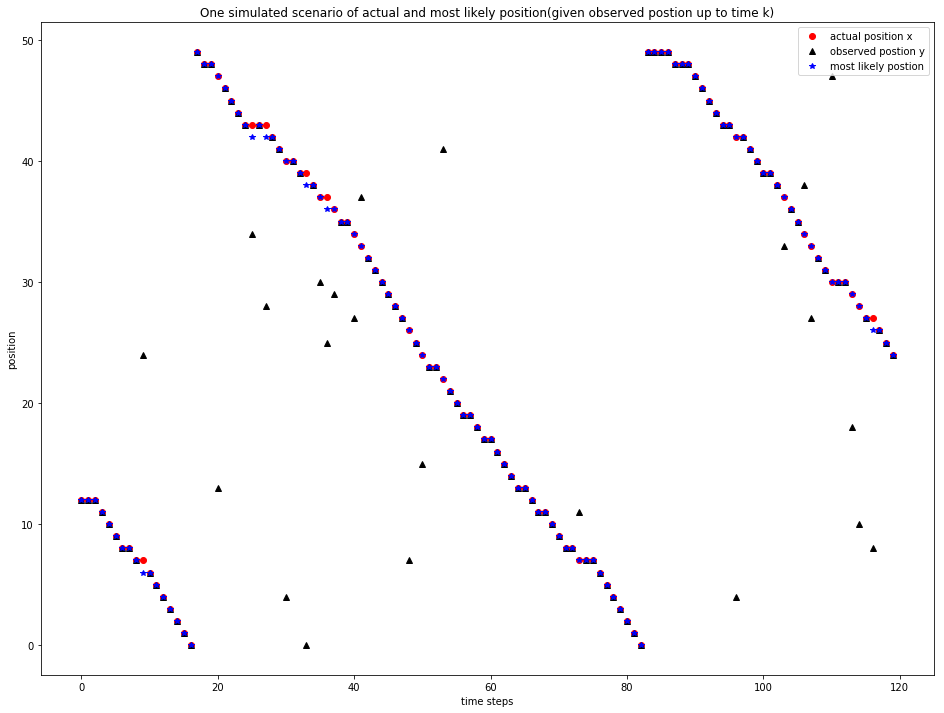

In [14]:
# compute (f) Most likely current position of the robot given the observations so far
import pandas

max_idx = pandas.DataFrame(p_xk_y1k).idxmax(axis=0)
max_probs = pandas.DataFrame(p_xk_y1k).max(axis=0)

plt.figure(figsize=(10, 8))  
plt.plot(timesteps, max_probs, 'b*', label='most likely postion probilities')  
plt.xlabel('time steps')
plt.ylabel('probabilities')
plt.legend()
plt.title('The probablities along the path for the most likely position')
plt.show() 


plt.figure(figsize=(16, 12))
plt.plot(timesteps, x,'ro', label="actual position x")
plt.plot(timesteps, y, 'k^', label='observed postion y') 
plt.plot(timesteps, max_idx, 'b*', label='most likely postion')  
plt.xlabel('time steps')
plt.ylabel('position')
plt.legend()
plt.title('One simulated scenario of actual and most likely position(given observed postion up to time k)')
plt.show()  



### Q1.6
Assume now that at each step the robot can be kidnapped with probability κ. If the robot is kidnapped its new position is independent from its previous position and is uniformly distributed. Repeat 4 and 5 for this new model with κ = 0.1. Can you reuse your code?




### Comment to Q1.6 

Sure, we can reuse the code. The only thing we need to change is the transition model. Now the transition matrix will be different with the previous one. 


$$p(x_{k+1}|x_k=i)= \begin{pmatrix}
 0   \\
...  \\
1 - \epsilon  \\
\epsilon  \\
...  \\
0 
\end{pmatrix} * (1 -\kappa) + 
\begin{pmatrix}
 1/N   \\
...  \\
 1/N  \\
  1/N \\
...  \\
  1/N
\end{pmatrix} * \kappa, \ with\ \  each\  row \  corresponding\ to \ x_{k+1} = \  
\begin{pmatrix}
 1   \\
...  \\
j \\
i  \\
...  \\
N 
\end{pmatrix}  $$




In [15]:
# Q1.6 
# update the tran_model

tran_model = np.zeros((N,N))  # column : x_i value, row x_{i+1} value
kappa = 0.1

# probility vecotor of the position of x1, x1 correponding to zero index in the matched matrix or vector
x1_prob = np.ones((N, 1)) / N 
#obs_model = obs_model * (1. - w) / N

for i in np.arange(N): 
    j = np.mod(i - 1 + N, N)
    # obs_model[i, i] = w + (1. - w) / N
    tran_model[i, i] = epsilon * (1 - kappa)
    tran_model[j, i] = (1 - epsilon) * (1 - kappa)
    tran_model[:, i] += kappa / N

print ('Updated transition model probablities matrix (column:' 
       + 'x_i, row x_{i+1}' + '): \n', tran_model, '\n')


Updated transition model probablities matrix (column:x_i, row x_{i+1}): 
 [[0.272 0.632 0.002 ... 0.002 0.002 0.002]
 [0.002 0.272 0.632 ... 0.002 0.002 0.002]
 [0.002 0.002 0.272 ... 0.002 0.002 0.002]
 ...
 [0.002 0.002 0.002 ... 0.272 0.632 0.002]
 [0.002 0.002 0.002 ... 0.002 0.272 0.632]
 [0.632 0.002 0.002 ... 0.002 0.002 0.272]] 



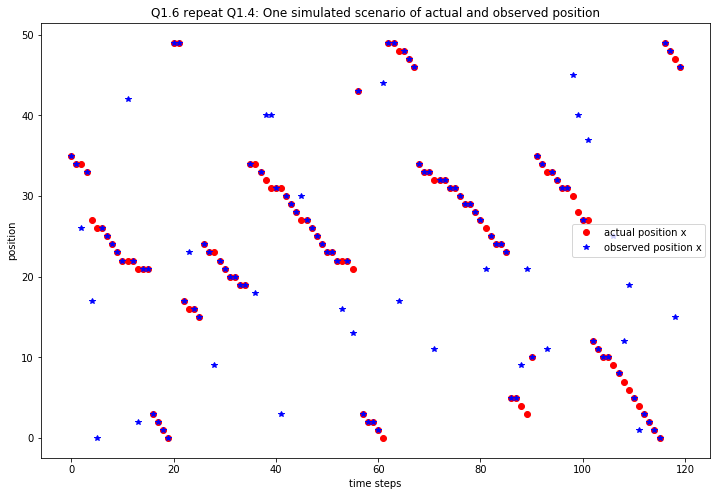

In [16]:
# Q1.6
# repeat  Q1.4 with the new trans_model

xs = np.zeros((nr_sc, nr_ts), dtype=int)
ys = xs.copy()

# simulator the trajectory 
for ti in np.arange(0,nr_ts):   
    for si in np.arange(0, nr_sc): 
        if ti == 0: # the initial position is uniformly distributed among the N positions with 1/N probablity
            xs[si,ti] = randint(0, N)      
        else: # pi > 0
            x_ti_prob = tran_model[:,xs[si,ti-1]]
            rand_prob = np.random.uniform(0,1)  
            idx_loc = sample_loc(rand_prob, x_ti_prob) 
            xs[si, ti] = idx_loc 
        y_ti_prob = obs_model[:,xs[si,ti]]
        rand_prob = np.random.uniform(0,1)  
        idx_loc = sample_loc(rand_prob, y_ti_prob) 
        ys[si,ti] = idx_loc
        
si = 5
timesteps = np.arange(0,nr_ts)
plt.figure(figsize=(12, 8))
plt.plot(timesteps, xs[si, :],'ro', label="actual position x")  
plt.plot(timesteps, ys[si, :], 'b*', label="observed position x")  
plt.xlabel('time steps')
plt.ylabel('position')
plt.legend()
plt.title('Q1.6 repeat Q1.4: One simulated scenario of actual and observed position')
plt.show()    



In [17]:
# Q1.6
# repeat Q1.5 with the new trans_model

# Forward Pass
alpha_1_0 = np.ones((N, 1)) / N  # alpha_1_0 = p(x_1)
# alpha_1_1 = obs_model.dot(alpha_1_0)  # alpha_1_1 = p(y_1|x_1)p(x_1) = p(y_1|x_1) alpha_1_0

# one scenario from the simulation
x = xs[si, :]
y = ys[si, :]

p = alpha_1_0.copy()
trans = tran_model.copy()  # transition model   p(x_k | x_{k_1})
obs = obs_model.copy()     # observation model  p(y_k | x_k)

log_trans = np.log(trans)
log_obs = np.log(obs)

# N: number of states/positions
# nr_ts: number of time steps

# Python indices start from zero so
log_alpha  = np.zeros((N, nr_ts))    # log \alpha_{k|k} will be in log_alpha[:,k-1]
log_alpha_pred = np.zeros((N, nr_ts))   # log \alpha_{k|k-1} will be in log_alpha_pred[:,k-1]

for ti in np.arange(nr_ts):
    if ti==0:
        log_alpha_pred[:,0] = np.log(p)[0]
    else:
        log_alpha_pred[:,ti] = predict(trans, log_alpha[:,ti-1])        
    
    log_alpha[:,ti] = update(y[ti], log_obs, log_alpha_pred[:,ti])  
    

# Backward Pass
log_beta  = np.zeros((N, nr_ts))      # beta_k|k
log_beta_post = np.zeros((N, nr_ts))  # beta_k|k+1


backward_range = np.arange(nr_ts - 1, -1, -1)
for ti in backward_range:
    if ti == nr_ts - 1:
        log_beta_post[:,ti] = np.zeros(N)
    else:
        log_beta_post[:,ti] = postdict(trans, log_beta[:,ti+1])
    log_beta[:,ti] = update(y[ti], log_obs, log_beta_post[:,ti])  

In [18]:
# Q1.6
# repeat Q1.5 with the new trans_model


# Q1.5 Compute (a) Distribution of the robot’s current position given the observations so far, i.e. the filtering distribution: 
#  i.e. p(xk|y1:k),  with  y1:k given!!!

# the p(xk|y1:k) value along all the time steps, given the observed position up to the corresponding time step
p_xk_y1k = np.zeros((N, nr_ts))

for k in np.arange(nr_ts): 
    log_alpha_kk = log_alpha[:,k]
    log_sum_alpha_kk = stable_logsumexp(log_alpha[:,k])
    log_p_xk_y1k = log_alpha_kk - log_sum_alpha_kk
    p_xk_y1k[:,k] = np.exp(log_p_xk_y1k)
    

sum_p_over_path = np.sum(p_xk_y1k, axis=0)
print("\nWe check whether the probablities summing up to 1 along the path!" , 
      "\n The sum of probablities at each time step \n: ", sum_p_over_path)
    
# random choose a k 
k = 10 - 1 
print ("\nWe print the probabilties of each position for a particular time step", 
       "\n given observed position up to time k,", 
       r'$p(x_k|y_{1:k})$ = ', '\n',  p_xk_y1k[:,k])


We check whether the probablities summing up to 1 along the path! 
 The sum of probablities at each time step 
:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

We print the probabilties of each position for a particular time step 
 given observed position up to time k, $p(x_k|y_{1:k})$ =  
 [0.00002 0.00002 0.00002 0.00002 0.00002 0.00002 0.00002 0.00002 0.00002
 0.00002 0.00002 0.00002 0.00002 0.00002 0.00002 0.00002 0.00002 0.00002
 0.00002 0.00002 0.00002 0.00002 0.00002 0.99709 0.00215 0.00002 0.00002
 0.00002 0.00002 0.00002 0.00002 0.00002 0.00002 0.00002 0.00002 0.00002
 0.00002 0.00002 0.00002 0.00002 0.00002 0.00002 0.00002 0.00002 0.00002
 0.00002 0.00002 0.00


We check whether the probablities summing up to 1 along the path! 
 The sum of probablities at each time step 
:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

We print the probabilties of each position for a particular time step, given all observed position! $p(x_k|y_{1:k})$ =  
 [0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.00001 0.99991 0.00008 0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.     ]


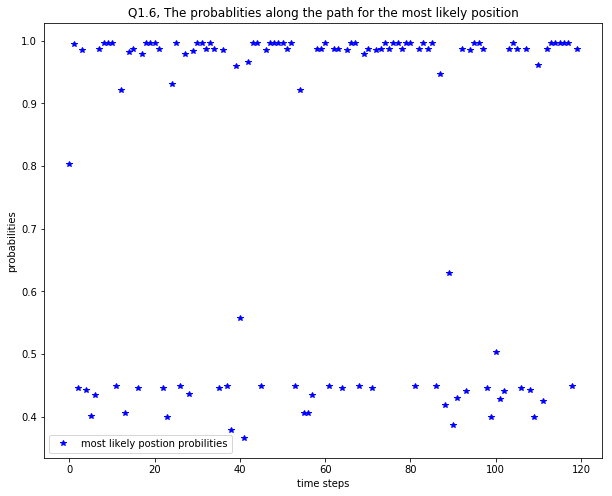

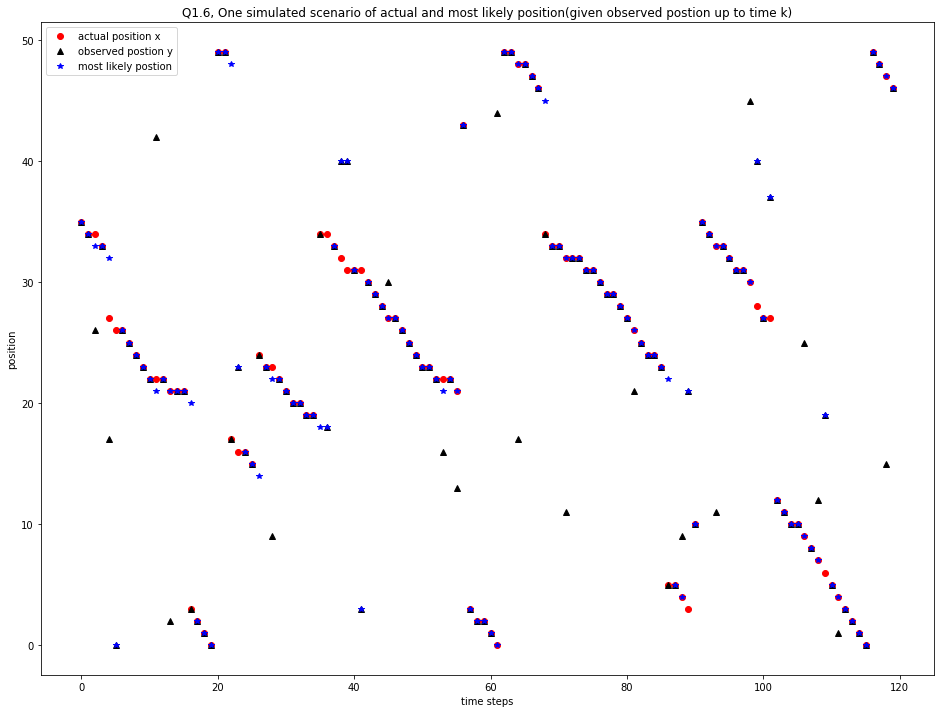

In [19]:
# Q1.6
# repeat Q1.5 with the new trans_model

# Q1.5(b) Distribution of the robot’s position at time step k given all the observations, i.e. the smoothing distribution: p(xk|y1:N)p(xk|y1:N). 

# the p(xk|y1:k) value along all the time steps, given the observation to the end
p_xk_y1N = np.zeros((N, nr_ts))

for k in np.arange(nr_ts): 
    log_alpha_kk = log_alpha[:,k]
    log_beta_post_kk = log_beta_post[:,k]
    log_sum_alpha_NN = stable_logsumexp(log_alpha[:, - 1])
    log_p_xk_y1N = log_alpha_kk +  log_beta_post_kk  -  log_sum_alpha_NN
    p_xk_y1N[:,k] = np.exp(log_p_xk_y1N)
    

sum_p_over_path = np.sum(p_xk_y1N, axis=0)
print("\nWe check whether the probablities summing up to 1 along the path!" , 
      "\n The sum of probablities at each time step \n: ", sum_p_over_path)
    
# random choose a k 
k = 10 - 1 
print ("\nWe print the probabilties of each position for a particular time step, given all observed position!", 
       r'$p(x_k|y_{1:k})$ = ', '\n',  p_xk_y1N[:,k])


# compute (f) Most likely current position of the robot given the observations so far
import pandas

max_idx = pandas.DataFrame(p_xk_y1k).idxmax(axis=0)
max_probs = pandas.DataFrame(p_xk_y1k).max(axis=0)

plt.figure(figsize=(10, 8))  
plt.plot(timesteps, max_probs, 'b*', label='most likely postion probilities')  
plt.xlabel('time steps')
plt.ylabel('probabilities')
plt.legend()
plt.title('Q1.6, The probablities along the path for the most likely position')
plt.show() 


plt.figure(figsize=(16, 12))
plt.plot(timesteps, x,'ro', label="actual position x")
plt.plot(timesteps, y, 'k^', label='observed postion y') 
plt.plot(timesteps, max_idx, 'b*', label='most likely postion')  
plt.xlabel('time steps')
plt.ylabel('position')
plt.legend()
plt.title('Q1.6, One simulated scenario of actual and most likely position(given observed postion up to time k)')
plt.show()  